# Exam Preparation: Ho-Lee

## Setup

In [46]:
import numpy as np
from scipy.stats import norm, ncx2, gamma
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Global settings for LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

# local
import fixed_income_derivatives as fid

## Fitting the Model

We consider the Ho-Lee model in which the short rate has dynamics
$$
d r_t=\Theta(t) d t+\sigma d W_t
$$

**Objective**: fit the model to observed forward rates extracted from the market. 
Assume that we observe the forward rates given in the vector $f^*$.
To estimate $\Theta(t)$ in the Ho-Lee model, we will fit a Nelson-Sigel type function $f(T)$ to the observed prices $f^*$.
$$
f(T)=f_{\infty}+a_0 e^{-b_0 T}+a_1 T e^{-b_1 T}+\ldots=f_{\infty}+a_0 e^{-b_0 T}+\sum_{k=1}^K a_k T^k e^{-b_k T}, \quad b_i>0
$$

How many terms to include in the fit is governed by $K$. We assume a functional form: Nelson-Siegel.
* More K than parameters.

### Plot Spot and Forward Rates

### Generate Synthetic Market Data

Firstly, we generate some market data we wish to fit to.

We plot the forward rates and spot rates generated by the function $f(T)$ for the maturities in the vector $T=[0,0.1, \ldots, 9.9,10]$ and parameters $\left[f_{\infty}, a_0, a_1, b_0, b_1\right]=[0.05,-0.02,0.01,0.5,0.4]$. Explain what role each parameter plays in the shape of the spot and forward rate curves.

In [47]:
M = 101
tau = np.array([0.1*i for i in range(0,M)]) # T=[0,0.1,..., 9.9,10]

# # Parameters used to generate the data
f_inf_star, a_star, b_star, sigma_star = 0.04, [-0.02,0.01,0.005], [0.01,0.2,0.8], 0.02
param = f_inf_star, a_star, b_star
f_star_data = fid.f_ns(param, tau)
#print(f_star_data)

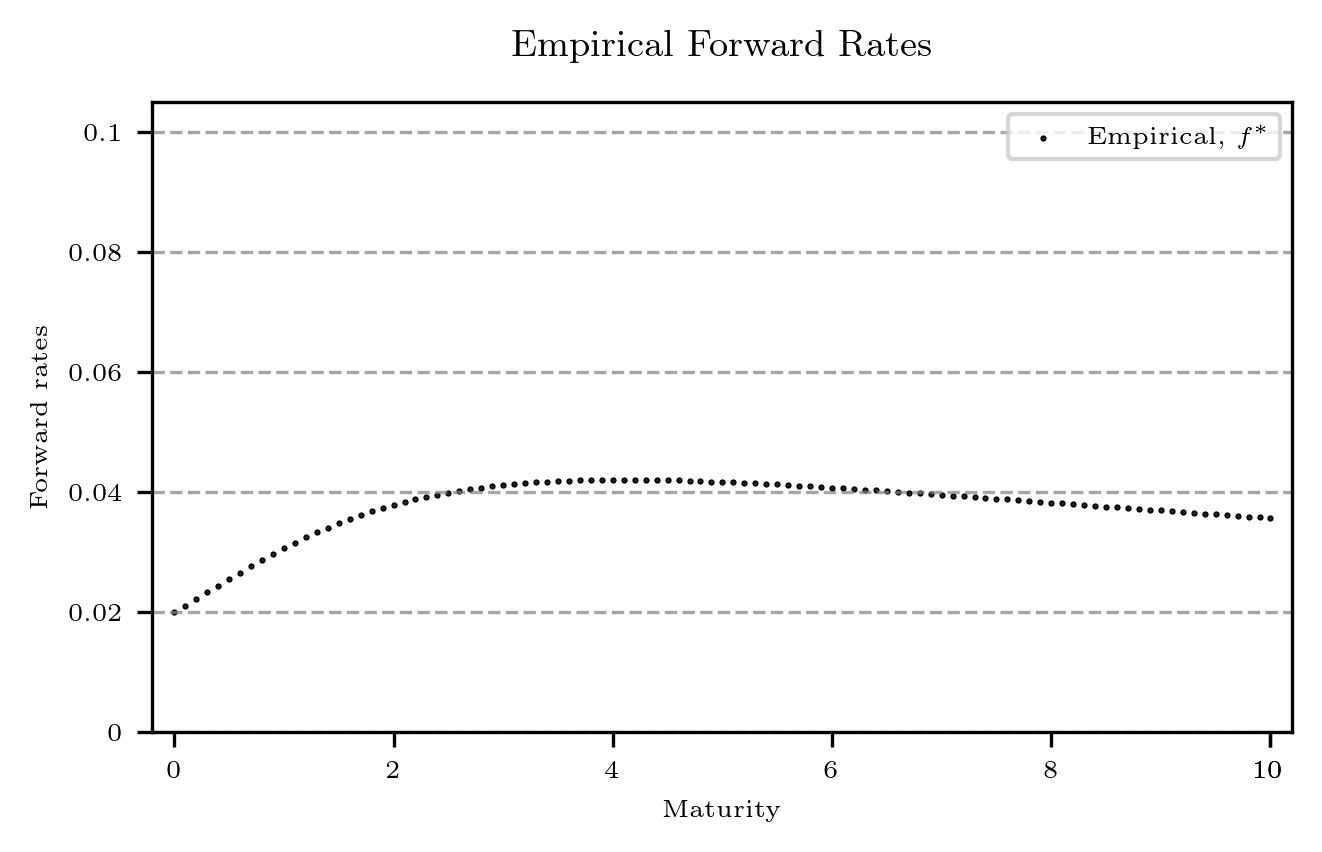

In [48]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig.suptitle(f"Empirical Forward Rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

xticks = [0,2,4,6,8,10,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08,0.1])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08,0.1],fontsize = 6)
ax.set_ylim([0,0.105])
ax.set_ylabel(f"Forward rates",fontsize = 6)
p1 = ax.scatter(tau, f_star_data, s = 1, color = 'black', marker = ".",label="Empirical, $f^*$")

plots = [p1]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 6)

plt.show()

* $f_{\infty}$ governs the long run behavior of the function, i.e. the long-term yield level.
    - as $T$ tends to infinity the two other terms goes to zero. As can be seen by letting the M be e.g. 1010 and the n
* $a_0$,$a_1$, and $a_2$ determines the relative weight on the long, short and medium term forward rate.
    * Short term behavior is primarily governed by $f_{\infty}+a_0$, where $a$ can be positive or negative. 
    * The higher order terms can produce a hump.
* $b_0$,$b_1$ ensures stability and smoothness.

# Fit the Model

Fit the function $f(T)$ to the observed values in $f^*$ using scipy.optimize and the 'nelder-mead' method. Your objective function should compute the total squared error between the fitted and observed values and hence, you should solve the following minimization problem
$$
\min \sum_{m=0}^M\left(f^*\left(T_m\right)-f\left(f_{\infty}, \mathbf{a}, \mathbf{b} ; T_m\right)\right)^2 \quad \text { wrt. } f_{\infty}, \mathbf{a}, \mathbf{b}
$$

In [49]:
# Initial (random) parameter values
f_inf_0 = (0.03,)
a_0 = -0.05, 0.03, 0.001
b_0 = 0.35, 0.35, 0.7
scaling = 10e10

In [50]:
K = len(a_0) - 1
param_0 = f_inf_0 + a_0 + b_0

In [51]:
# find optimal parameters
result = minimize(fid.fit_forward_rate_ns_obj,param_0,method = 'nelder-mead',args = (f_star_data,tau,scaling),options={'xatol': 1e-8,'disp': True})
f_inf_hat, a_hat, b_hat, fct_value = result.x[0], result.x[1:1+K+1], result.x[K+2:K+2+K+1], result.fun
print(f"f_inf_hat: {f_inf_hat}, a_hat: {a_hat}, b_hat: {b_hat}")

# fit using optimal parameters
f_fit = fid.f_ns((f_inf_hat,a_hat,b_hat),tau)
print(f"r0: {f_fit[0]}")

f_inf_hat: 0.026526120229697185, a_hat: [-0.0068237   0.01033766  0.00336712], b_hat: [0.22401184 0.2370159  0.79081174]
r0: 0.019702422609801908


/var/folders/3j/22yv_sj10t96slp1b8b6z1zw0000gn/T/ipykernel_40522/3100176748.py:2: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(fid.fit_forward_rate_ns_obj,param_0,method = 'nelder-mead',args = (f_star_data,tau,scaling),options={'xatol': 1e-8,'disp': True})


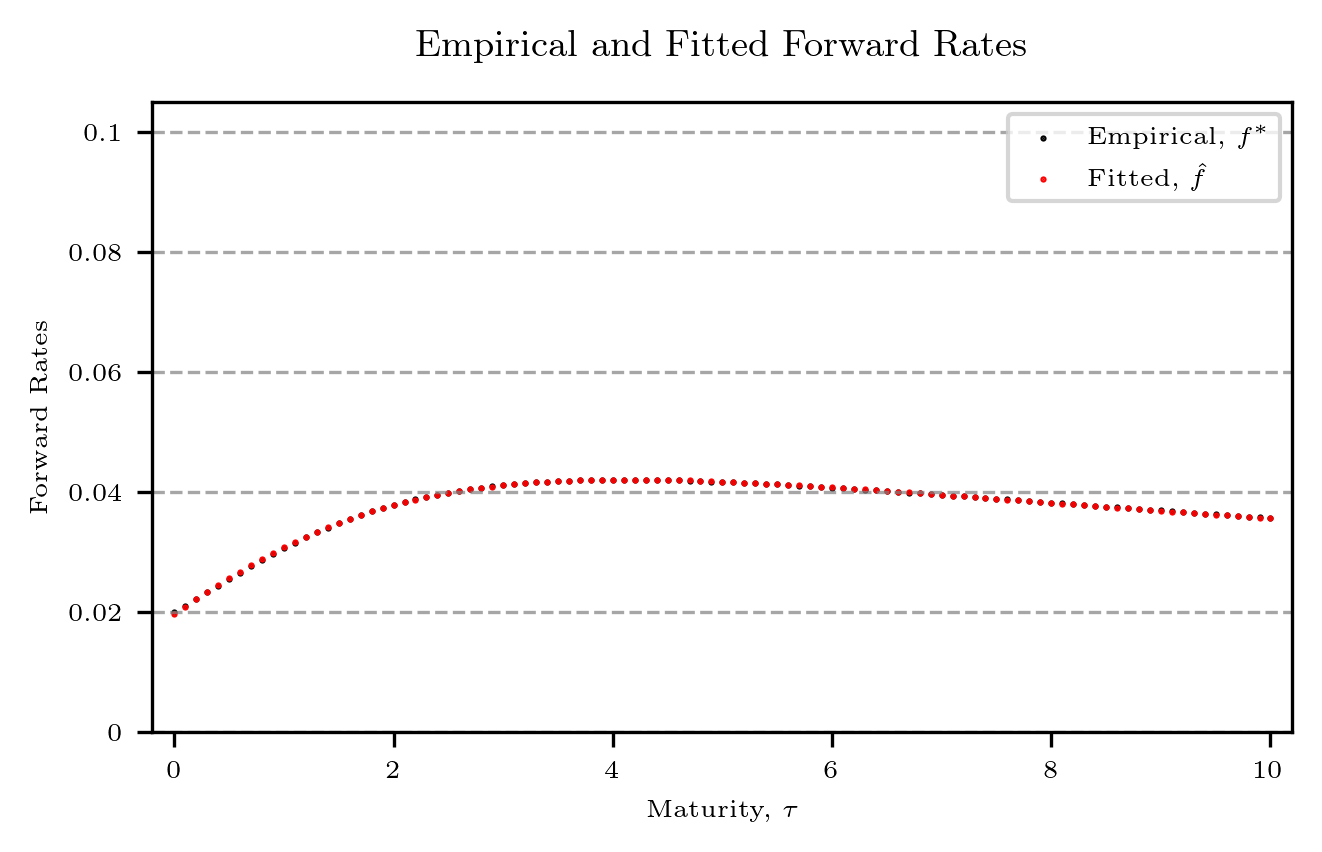

In [52]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig.suptitle(f"Empirical and Fitted Forward Rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity, $\\tau$",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08,0.1])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08,0.1],fontsize = 6)
ax.set_ylim([0,0.105])
ax.set_ylabel(f"Forward Rates",fontsize = 6)
p1 = ax.scatter(tau, f_star_data, s = 1, color = 'black', marker = ".",label="Empirical, $f^*$")
p2 = ax.scatter(tau, f_fit, s = 1, color = 'red', marker = ".",label="Fitted, $\hat{f}$")

plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 6)

plt.show()

The fitted values are more or less smack on.

#### Varying over K (Governening the Number of Terms)

We fit recursively for increasing values of $K$ starting with $K=1$ and try to go up to no more than $K=4$. Plot the fitted values $\hat{f}(T)$ versus the observed values $f^*(T)$.

In [53]:
# Initial (random) parameter values
f_inf_0 = (0.03,)
a_0 = -0.05, 0.03, 0.001
b_0 = 0.35, 0.35, 0.7
scaling = 10e10

In [54]:
K_array = [len(a_0) - 2, len(a_0)-1, len(a_0)] # K = 1, 2, 3
param_0 = f_inf_0 + a_0 + b_0

In [55]:
results = []  # List to store each output array

for K in range(0, len(K_array)):
    # find optimal parameters
    result = minimize(fid.fit_forward_rate_ns_obj,param_0,method = 'nelder-mead',args = (f_star_data,tau,scaling),options={'xatol': 1e-8,'disp': True})
    f_inf_hat, a_hat, b_hat, fct_value = result.x[0], result.x[1:1+K+1], result.x[K+2:K+2+K+1], result.fun
    print(f"f_inf_hat: {f_inf_hat}, a_hat: {a_hat}, b_hat: {b_hat}")
    f_fit_array = fid.f_ns((f_inf_hat, a_hat, b_hat), tau)
    results.append(f_fit_array)  # Store the output array in the results list
    print(f"r0: {f_fit_array[K]}")

/var/folders/3j/22yv_sj10t96slp1b8b6z1zw0000gn/T/ipykernel_40522/2392676609.py:5: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(fid.fit_forward_rate_ns_obj,param_0,method = 'nelder-mead',args = (f_star_data,tau,scaling),options={'xatol': 1e-8,'disp': True})


f_inf_hat: 0.026526120229697185, a_hat: [-0.0068237], b_hat: [0.01033766]
r0: 0.019702422609801908
f_inf_hat: 0.026526120229697185, a_hat: [-0.0068237   0.01033766], b_hat: [0.00336712 0.22401184]
r0: 0.020715585332923524
f_inf_hat: 0.026526120229697185, a_hat: [-0.0068237   0.01033766  0.00336712], b_hat: [0.22401184 0.2370159  0.79081174]
r0: 0.02208818540722119


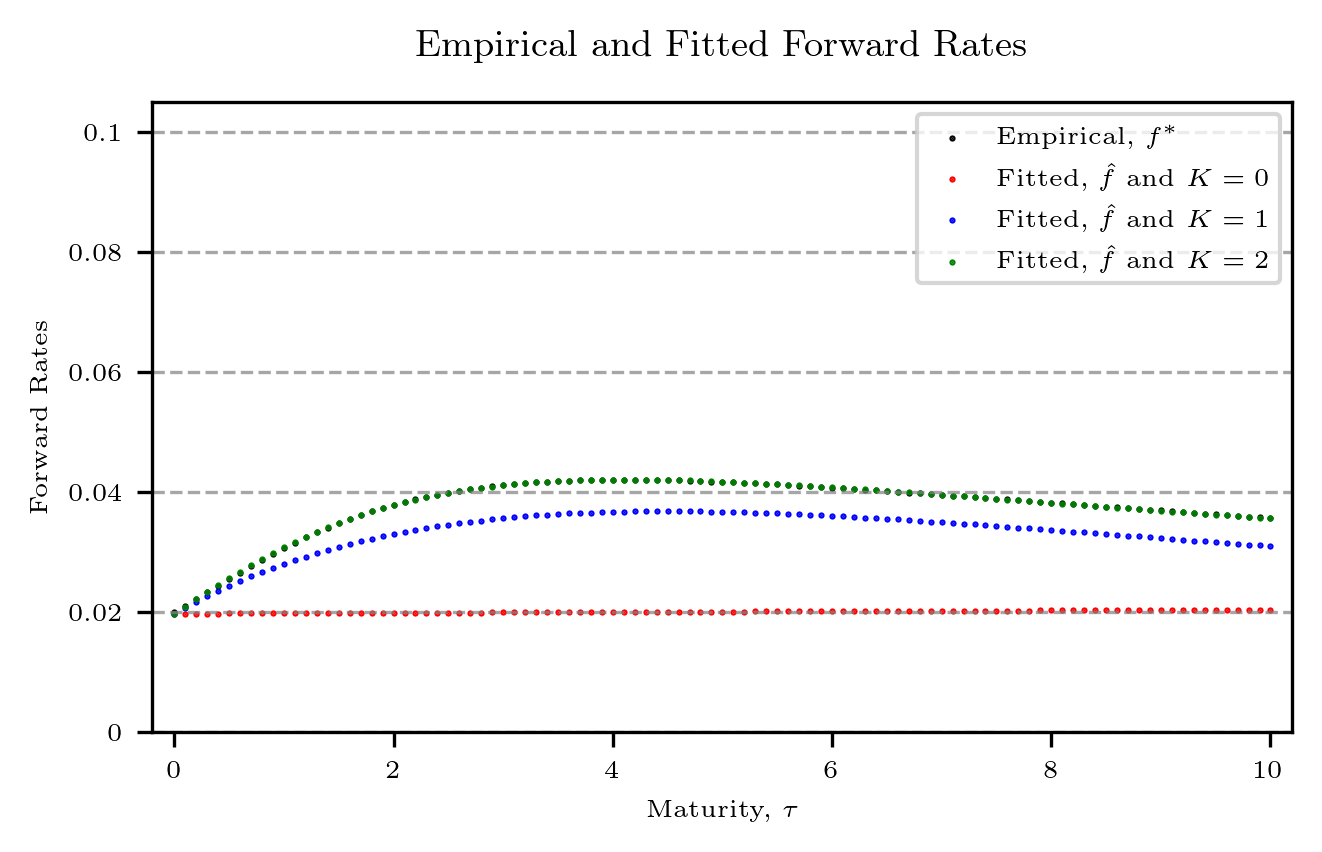

In [56]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig.suptitle(f"Empirical and Fitted Forward Rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity, $\\tau$",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08,0.1])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08,0.1],fontsize = 6)
ax.set_ylim([0,0.105])
ax.set_ylabel(f"Forward Rates",fontsize = 6)
p1 = ax.scatter(tau, f_star_data, s = 1, color = 'black', marker = ".",label="Empirical, $f^*$")
p2 = ax.scatter(tau, results[0], s = 1, color = 'red', marker = ".",label="Fitted, $\hat{f}$ and $K=0$")
p3 = ax.scatter(tau, results[1], s = 1, color = 'blue', marker = ".",label="Fitted, $\hat{f}$ and $K=1$")
p4 = ax.scatter(tau, results[2], s = 1, color = 'green', marker = ".",label="Fitted, $\hat{f}$ and $K=2$ ")

plots = [p1,p2,p3,p4]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 6)

plt.show()

### Constrained Optimization

In [57]:
result = minimize(fid.fit_forward_rate_ns_obj, param_0, method='Newton-CG',args = (f_star_data,tau,scaling),jac = fid.fit_forward_rate_ns_jac, hess=fid.fit_forward_rate_ns_hess,options={'maxiter': 5000, 'xtol': 1e-12, 'disp': False})
f_inf_hat, a_hat, b_hat, fct_value = result.x[0], result.x[1:1+K+1], result.x[K+2:K+2+K+1], result.fun
print(f"f_inf_hat: {f_inf_hat}, a_hat: {a_hat}, b_hat: {b_hat}")
f_fit = fid.f_ns((f_inf_hat,a_hat,b_hat),tau)
print(f"ro: {f_fit[0]}")

f_inf_hat: 0.03343006178808813, a_hat: [-0.01469886  0.00955473  0.00233557], b_hat: [0.34925724 0.33975435 0.69685856]
ro: 0.018731204191325117


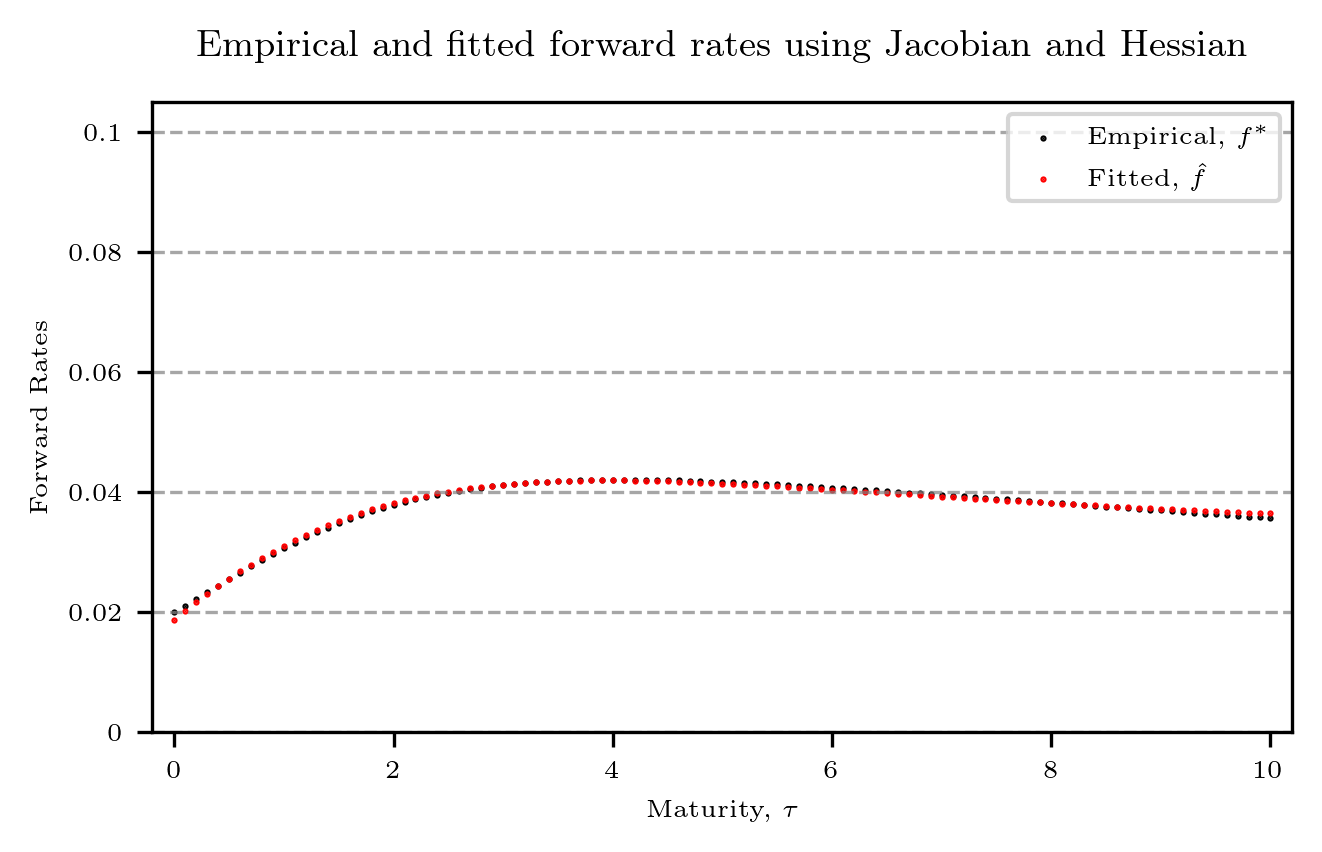

In [58]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig.suptitle(f"Empirical and fitted forward rates using Jacobian and Hessian", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity, $\\tau$",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08,0.1])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08,0.1],fontsize = 6)
ax.set_ylim([0,0.105])
ax.set_ylabel(f"Forward Rates",fontsize = 6)
p1 = ax.scatter(tau, f_star_data, s = 1, color = 'black', marker = ".",label="Empirical, $f^*$")
p2 = ax.scatter(tau, f_fit, s = 1, color = 'red', marker = ".",label="Fitted, $\hat{f}$")

plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 6)

plt.show()

We can sometimes improve the minimization function by providing the derivatives.
Here it takes a bit longer and the fit is not as good, illustrating that a more complex solution is not always as good. However, generally this method is preferred, but our code is not efficient as we could have made use of the fact that many of matrices are zero.

### Compute Drift $\Theta$

Given choice of $K$ and preferred parameter estimates, find the function $\Theta(t)$ in the drift of the Ho-Lee model using that
$$
\Theta(t)=\frac{\partial f^*(0, t)}{\partial T}+\sigma^2 t
$$
where $\frac{\partial f^*(0, t)}{\partial T}$ denotes derivative in the second argument of $f^*$ evaluated at $(0, t)$.

In [59]:
param = (f_inf_star, a_star, b_star, sigma_star)
fid.theta_ns(param,tau)

array([0.0102    , 0.01073194, 0.01107112, 0.01124869, 0.01129173,
       0.01122382, 0.01106536, 0.01083398, 0.01054488, 0.01021112,
       0.00984383, 0.00945252, 0.00904524, 0.00862876, 0.00820875,
       0.00778992, 0.00737613, 0.00697055, 0.00657568, 0.0061935 ,
       0.00582555, 0.00547293, 0.00513645, 0.00481661, 0.00451367,
       0.00422772, 0.00395864, 0.00370621, 0.0034701 , 0.00324987,
       0.00304503, 0.00285503, 0.0026793 , 0.00251723, 0.00236818,
       0.00223154, 0.00210666, 0.00199293, 0.00188972, 0.00179645,
       0.00171252, 0.00163738, 0.00157047, 0.00151129, 0.00145933,
       0.00141412, 0.00137521, 0.00134218, 0.00131463, 0.00129217,
       0.00127446, 0.00126116, 0.00125196, 0.00124657, 0.00124471,
       0.00124612, 0.00125058, 0.00125786, 0.00126776, 0.00128009,
       0.00129467, 0.00131134, 0.00132995, 0.00135036, 0.00137245,
       0.0013961 , 0.00142119, 0.00144763, 0.00147533, 0.0015042 ,
       0.00153416, 0.00156515, 0.00159709, 0.00162993, 0.00166

## Price Asian Derivative

**A common practice in finance:**
1) We observe prices in market
2) Fit model to prices
3) Compute something more exotic (not priced in the market) using the fitted model


**Introduction**
We consider an Asian-style derivative which at maturity $S=1$ pays the average short rate over the period from $t=0$ to $S=1$ provided the average short rate is positive. The contract function for this option is in other words
$$
\chi(S)=\frac{1}{S} \max \left(\int_0^S r_u d u, 0\right)=\frac{1}{S}\left(\int_0^S r_u d u\right)_{+}
$$

**How to Compute price of Derivative**:
1) Compute: $\chi_1(S)=\frac{1}{S} \sum_{\mathrm{m}=0}^{\mathrm{M}} r_m$
    - i.e. Simulate the short rate previsouly obtained parameters and $\sigma=0.03$. Denote by $\mathrm{M}$, the number of steps in your simulation. The time points in your simulation will be numbered $m=0,1,2, \ldots, M-1, M$ and the time points will be $\left[t_0, t_1, \ldots, t_{M-1}, t_M\right]=[0, \delta, 2 \delta, \ldots, S-\delta, S]$ and $\delta=\frac{S}{M}$. The scheme you will need to implement is a simple Euler first-order scheme of the form
$$
r_m=r_{m-1}+\Theta\left(t_{m-1}\right) \delta+\sigma \sqrt{\delta} Z_m, \quad m=1,2, \ldots, M
$$
where $Z_m \sim N(0,1), m=1, \ldots, M$ and all the standard normal random variables are independent.
2) This we do for $N$ simulations to get:
$$
\chi_N(S) =\frac{1}{N} \sum_{n=1}^N \chi_n(S)
$$
Notice this Asian type derivative pays the average.

In [68]:
# parameters obtained from earlier
f_inf_hat = 0.0470857723425845
r0 = 0.01946854287371834
a_hat = [-0.02761198, 0.01251315, 0.00146974]
b_hat = [0.38773133, 0.28801503, 0.68312069]
sigma = 0.03
N = 1000
M, T = 1000, 1

param = f_inf_hat, a_hat, b_hat, sigma

# Function to compute the price of the Asian derivative
def compute_asian_derivative_price(N, r0, param, M, T):
    chi = 0
    for n in range(0,N):
        r = fid.short_rate_simul(r0, param, M, T, method="ho_lee_ns")
        #chi += np.exp(-sum(r)*(T/N))*(sum(r)/(M+1),0)
        chi += np.exp(-sum(r)*(T/N))*max(sum(r)/(M+1),0)
    return chi / N

price = compute_asian_derivative_price(N, r0, param, M, T)
print(f"Price of the Asian derivative: {price:.8f}")

Price of the Asian derivative: 0.02889486


We run the above scheme for increasing values of $N$ and plot the value of the derivative as a function of $N$. Assess how large $N$ has to be for your scheme to have converged and for the price you computed to be reasonably accurate.

In [ ]:
# Simulating for increasing values of N and plotting
N_values = np.linspace(10, 10_000, 50, dtype=int) 
asian_derivative_prices = []

for N in N_values:
    price = compute_asian_derivative_price(N, r0, param, M, T)
    asian_derivative_prices.append(price)

In [ ]:
# Creating a plot with the specified style and layout
fig = plt.figure(constrained_layout=False, dpi=300, figsize=(5, 3))
fig.suptitle("Price of Asian Derivative as a Function of the Number of Simulations", fontsize=9)
gs = fig.add_gridspec(nrows=1, ncols=1, left=0.12, bottom=0.2, right=0.88, top=0.90, wspace=0, hspace=0)
ax = fig.add_subplot(gs[0, 0])
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

plt.xlabel("Number of Simulations, $N$", fontsize=6)
ax.set_ylabel("Price of Asian Derivative", fontsize=6)

# Plotting the Asian derivative prices
ax.plot(N_values, asian_derivative_prices, color='black', marker='', linewidth=1., label="Asian Derivative Price")

ax.legend(loc="lower right", fontsize=6)
plt.show()

Notice, it converges with rate $\sqrt{n}$ as a function of $N$ (we could explore $N$ and $M$ țrade-off).